In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pathlib import Path
from urllib.request import urlretrieve
PATH_TO_DATA = Path('')
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1- Chargement des données


In [0]:
import os
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import codecs
from os import path

# Read training data
with open("train.csv", 'r') as f:
    train_data = f.read().splitlines()

train_hosts = list()
y_train = list()
for row in train_data:
    host, label = row.split(",")
    train_hosts.append(host)
    y_train.append(label.lower())

# Read test data
with open("test.csv", 'r') as f:
    test_hosts = f.read().splitlines()

# Load the textual content of a set of webpages for each host into the dictionary "text". 
# The encoding parameter is required since the majority of our text is french.
text = dict()
#filenames = os.listdir("text/")
import tqdm

import numpy as np
import gzip
class Word2Vec():
    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}

    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)

    def encode(self, word):
        ind_word = [self.word2id[w] for w in word]
        return self.embeddings[ind_word] 
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        if type(word1) == str :
            w1 = self.encode(word1)
            w2 = self.encode(word2)
        else :
            w1 = word1; w2 = word2
        return np.dot(w1, w2)/(np.linalg.norm(w1)*np.linalg.norm(w2)) ## cosine similarity
        
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        sim = np.zeros(len(self.words))
        w1 = self.encode(word)
        for i in range(self.embeddings.shape[0]) :
            sim[i] = self.score(w1, self.embeddings[i])
        inds = np.argsort(sim)[-k-1:][::-1]
        words = [self.words[i] for i in inds[1:]] ## We don't count the word in input
        return words

    def encode_sentence(self, sentence):
        sent_emb = []
        sent = []
        for word in sentence :
            try :
                #import pdb; pdb.set_trace()
                sent_emb.append(self.embeddings[self.word2id[word]])
                sent.append(word)
            except :
                pass 
        return np.array(sent_emb)        
class BagOfWords():
  def __init__(self, word2vec):
    self.word2vec = word2vec
  def encode(self, sentence):
      # Takes a sentence as input, returns the sentence embedding
    allwords = self.word2vec.words
    words_emb = []
    words = np.intersect1d(sentence, allwords)
    if len(words) == 0 :
        print(' ')
        print(sentence)
        words_emb.append(np.ones(300)/300)
    else :
        words_emb.append(np.mean(self.word2vec.encode(words), axis = 0))
    return np.array(words_emb)
fr_embeddings_path = 'cc.fr.300.vec.gz'
word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)

Loaded 50000 pretrained word vectors


In [0]:
#!cp /content/drive/'My Drive'/text_data.zip /content/
#!unzip text_data.zip
#!cp -r keep/* text/

In [0]:
import networkx as nx
import numpy as np
import tqdm
G = nx.read_weighted_edgelist('edgelist.txt', create_using=nx.DiGraph())
text = {}
filenames = os.listdir("text/")
for node in tqdm.tqdm(train_hosts) :
    if (node not in text.keys()) & (node in filenames) :
        with codecs.open(path.join("text/", node), encoding='utf-8', errors = 'ignore') as f: 
            tokens = f.read().replace("\n", "").lower()
            #_, ind_tokens, __ = np.intersect1d(tokens, word2vec.words,return_indices=True )
            #tokens = np.array(tokens)[np.sort(ind_tokens)]          
            text[node] = tokens
    if node in G.nodes():    
        for neigh in G.neighbors(node) :
            if (neigh in filenames) & (neigh not in text.keys()):
                with codecs.open(path.join("text/", neigh), encoding='utf-8', errors = 'ignore') as f: 
                    tokens = f.read().replace("\n", "").lower()
                    #_, ind_tokens, __ = np.intersect1d(tokens, word2vec.words,return_indices=True )
                    #tokens = np.array(tokens)[np.sort(ind_tokens)]
                    text[neigh] = tokens 
for node in tqdm.tqdm(test_hosts) :
    if (node not in text.keys()) & (node in filenames) :
        with codecs.open(path.join("text/", node), encoding='utf-8', errors = 'ignore') as f: 
            tokens = f.read().replace("\n", "").lower()
            #_, ind_tokens, __ = np.intersect1d(tokens, word2vec.words,return_indices=True )
            #tokens = np.array(tokens)[np.sort(ind_tokens)]          
            text[node] = tokens
    if node in G.nodes():    
        for neigh in G.neighbors(node) :
            if (neigh in filenames) & (neigh not in text.keys()):
                with codecs.open(path.join("text/", neigh), encoding='utf-8', errors = 'ignore') as f: 
                    tokens = f.read().replace("\n", "").lower()
                    #_, ind_tokens, __ = np.intersect1d(tokens, word2vec.words, return_indices=True )
                    #tokens = np.array(tokens)[np.sort(ind_tokens)]
                    text[neigh] = tokens

100%|██████████| 560/560 [00:11<00:00, 49.39it/s]


# 2-Préparation données

In [0]:
#import pickle
#with open("/content/drive/My Drive/filename.pickle", 'rb') as handle:
#    text_before = pickle.load(handle)
#print(len(text_before))

23471


In [0]:
test_dict = {key:' '.join(value) for key, value in text.items()}

In [0]:
#del text_before; import gc; gc.collect()

0

In [0]:
!python -m spacy download fr_core_news_md
import spacy
nlp = spacy.load('fr_core_news_md')

     |████████████████████████████████| 85.7MB 51.1MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.1.0-cp36-none-any.whl size=87463874 sha256=324bc59b89e974eca07c744bd3b6356ace3b436ce289b1ce2b9463e5dee8b319
  Stored in directory: /tmp/pip-ephem-wheel-cache-k8adf602/wheels/7e/91/64/f61e597321455d6e42a76abac5736d919a265c31be451cc1ba
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [0]:
train_hosts, index_hosts = np.unique(train_hosts, return_index=True)
y_train = np.array(y_train)[index_hosts]

train_data = list()
train_data_empty = []
train_data_empty_treated = []
for i, host in enumerate(train_hosts):
    if len(np.unique(test_dict[host].split())) >= 30 :
        train_data.append(test_dict[host].split())
    else:
        train_data.append(test_dict[host].split())
        for k, neigh in enumerate(G.neighbors(host)) :
          if len(np.unique(train_data[i])) < 100 :
            train_data[i] = train_data[i] + test_dict[neigh].split()
        if len(train_data[i]) == 0 :
            train_data_empty.append([i, host])
        else :
            train_data_empty_treated.append([i, host])
        test_dict[host] = ' '.join(train_data[i])

In [0]:
test_data = list()
test_data_empty = []
test_data_empty_treated = []
for i, host in enumerate(test_hosts):
    if len(np.unique(test_dict[host].split())) >= 30 :
        test_data.append(test_dict[host].split())
    else:
        test_data.append(test_dict[host].split())
        for k, neigh in enumerate(G.neighbors(host)) :
          if len(np.unique(test_data[i])) < 100 :
            test_data[i] = test_data[i] +  test_dict[neigh].split()
        if len(test_data[i]) == 0 :
            test_data_empty.append([i, host])
        else :
            test_data_empty_treated.append([i, host])
        test_dict[host] = ' '.join(test_data[i])

In [0]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('stopwords'); nltk.download('punkt'); nltk.download('wordnet')
stop_words = set(stopwords.words('french')).union(set(stopwords.words('english')))
def tokenize(train_data) :
    res = [] 
    for key in tqdm.tqdm(train_data) :
        try :
          tokens = nlp(' '.join(key))
          #_, ind_tokens, __ = np.intersect1d(tokens, word2vec.words,return_indices=True )
          #tokens = np.array(tokens)[np.sort(ind_tokens)]
          result = [i.lemma_ for i in tokens if( (len(i) > 2) &  (i.is_alpha) & (i not in stop_words)) ]
          res.append(result)
        except :
          tokens = nlp(' '.join(key[:200]))
          result = [i.lemma_ for i in tokens if( (len(i) > 2) &  (i.is_alpha) & (i not in stop_words)) ]
          res.append(result)
    return res
train_data = tokenize(train_data)
train_data = [' '.join(x) for x in train_data]
test_data = tokenize(test_data) 
test_data = [' '.join(x) for x in test_data]

100%|██████████| 1994/1994 [02:52<00:00, 11.58it/s]


In [0]:
for i, host in tqdm.tqdm(enumerate(train_hosts)) :
  tmp = [x for x in train_data[i].split() if x not in stop_words]
  train_data[i] = ' '.join(tmp)
for i, host in tqdm.tqdm(enumerate(test_hosts)) :
  tmp = [x for x in test_data[i].split() if x not in stop_words]
  test_data[i] = ' '.join(tmp)

1994it [00:00, 9194.25it/s]
560it [00:00, 8529.19it/s]


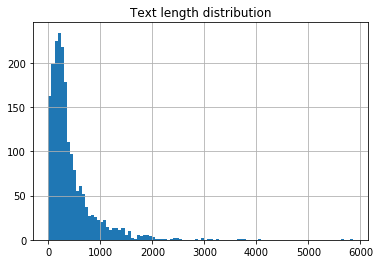

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
tmp = pd.Series([len(i.split()) for i in train_data])
tmp.hist(bins = 100)
plt.title('Text length distribution');
plt.savefig('length_distribution.png', dpi=80)

# 3- Split train test and applying baseline

In [0]:
from sklearn.model_selection import train_test_split
train_index, val_index = train_test_split(index_hosts, test_size=0.15, random_state=42, stratify= y_train)
train_data_, val_data_ = [train_data[i] for i in train_index], [train_data[i] for i in val_index]
Y_train, y_val = [y_train[i] for i in train_index], [y_train[i] for i in val_index]

In [0]:
vec = TfidfVectorizer(decode_error='ignore', smooth_idf=False, stop_words=stop_words,
                      encoding='utf-8', min_df=15, max_df=2000)
df_train = vec.fit_transform(train_data_)
df_val = vec.transform(val_data_)

In [0]:
df_train.shape

(1694, 6502)

In [0]:
###logistic regression
import sklearn
def my_score (y_true, y_pred) :
    return -sklearn.metrics.log_loss(y_true, y_pred)
my_score = sklearn.metrics.make_scorer(my_score, needs_proba=True)
from sklearn import linear_model
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import sklearn
logistic = linear_model.LogisticRegression()
C = np.logspace(-1, 2, 20)
params = dict(C=C, solver=['lbfgs'], max_iter=[1000], penalty=['l2'], multi_class=['auto'])
clf = GridSearchCV(logistic, params, cv=2, verbose=10, n_jobs = -1,  scoring=my_score)
clf = clf.fit(df_train, Y_train)
clf_good = clf.best_estimator_
y_pred_val = clf_good.predict_proba(df_val)
print(sklearn.metrics.log_loss(y_val, y_pred_val))

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   47.6s finished


1.2603580315152991


In [0]:
## For using the prediction of TF-idf as attributes of the nodes of the graph
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, random_state=1, shuffle=True)
y_pred_final = np.zeros((df_train.shape[0], 8))
for id_train, id_test in kf.split(df_train):
    X_train, X_test = df_train[id_train],  df_train[id_test]
    Y_train_, y_test = np.array(Y_train)[id_train], np.array(Y_train)[id_test]
    clf_good.fit(X_train, Y_train_)
    y_pred = clf_good.predict_proba(X_test)
    y_pred_final[id_test] = y_pred
    print(sklearn.metrics.log_loss(y_test, y_pred))

1.2897621087821687
1.3070664765055273
1.309150810121698


In [0]:
for i, host in tqdm.tqdm(enumerate(train_hosts)) :
  tmp = [x for x in train_data[i].split() if x not in stop_words]
  test_dict[host] = train_data[i]
for i, host in tqdm.tqdm(enumerate(test_hosts)) :
  tmp = [x for x in test_data[i].split() if x not in stop_words]
  test_dict[host] = test_data[i]

1994it [00:00, 10748.45it/s]
560it [00:00, 12225.87it/s]


In [0]:
## saving the prediction on the test set of the best model obtained with a grid search CV
y_pred = clf_good.fit(vec.transform(train_data), y_train).predict_proba(vec.transform(test_data))
with open('text_baseline_last.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list(np.unique(y_train))
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i, test_host in enumerate(test_hosts):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

# 4- Our final model

In [0]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('stopwords'); nltk.download('punkt'); nltk.download('wordnet')
stop_words = set(stopwords.words('french')).union(set(stopwords.words('english')))
def tokenize(train_data) :
    res = [] 
    for key in tqdm.tqdm(train_data) :
        try :
          tokens = nlp(' '.join(key))
          _, ind_tokens, __ = np.intersect1d(tokens, word2vec.words,return_indices=True )
          tokens = np.array(tokens)[np.sort(ind_tokens)]
          result = [i.lemma_ for i in tokens if( (len(i) > 2) &  (i.is_alpha) & (i not in stop_words)) ]
          res.append(result)
        except :
          tokens = nlp(' '.join(key[:200]))
          result = [i.lemma_ for i in tokens if( (len(i) > 2) &  (i.is_alpha) & (i not in stop_words)) ]
          res.append(result)
    return res
train_data = tokenize(train_data)
train_data = [' '.join(x) for x in train_data]
test_data = tokenize(test_data) 
test_data = [' '.join(x) for x in test_data]

In [0]:
train_hosts_ = [train_hosts[i] for i in train_index]
val_hosts = [train_hosts[i] for i in val_index]

## Slicing the texts

In [0]:
import pandas as pd
n_slice = 30
def get_slice(sentence, n=n_slice, max_chunks=10) :
    sentence = sentence.split()
    chunks = [sentence[i * n:(i + 1) * n] for i in range((len(sentence) + n - 1) // n )]
    return chunks[: max_chunks]
df = pd.DataFrame(data=train_hosts, columns=['hosts'])
df['target'] = y_train
#df['new_feat'] = y_pred_final
df_ = pd.DataFrame.from_dict(test_dict, orient='index').reset_index()
df_.columns = ['hosts', 'text']
#df_.hosts = df_.hosts.astype(int)
df = df.merge(df_, on='hosts', how='inner')
df['text_new'] = df.text.apply(get_slice)
df = df.set_index(['hosts', 'target']).drop(columns = ['text'])
df = df.explode('text_new').reset_index()
df = df[df.text_new.notnull()]
#df = df[df.len >= 15]
print(df.shape)
y_train_ = df.target.tolist()
train_data_ = df.text_new.tolist()

## Données Test
df_test = pd.DataFrame(data=test_hosts, columns=['hosts'])
df_ = pd.DataFrame.from_dict(test_dict, orient='index').reset_index()
df_.columns = ['hosts', 'text']
df_test = df_test.merge(df_, on='hosts', how='inner')
df_test['text_new'] = df_test.text.apply(get_slice)
df_test = df_test.set_index(['hosts']).drop(columns = ['text'])
df_test = df_test.explode('text_new').reset_index()
#f_test = df_test[df_test.len >=15]
test_data_ = df_test.text_new.tolist()
print(df_test.shape)
def get_index(sentence) :
    ind_words = []
    try :
        for word in sentence :
            try :
                ind_words.append(word2vec.word2id[word])
            except :
                pass
    except :
        pass
    return ind_words
result_test = [get_index(w) for w in test_data_]
result_train = [get_index(w) for w in train_data_]

(19261, 3)
(5306, 2)


In [0]:
## Pour l'entraînement
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
df['result'] = result_train
import pandas as pd
df['train'] = df.hosts.isin(train_hosts_)
df['val'] = df.hosts.isin(val_hosts)
y_train__ = pd.get_dummies(df[df.train].target).values
y_val_ = pd.get_dummies(df[df.val].target).values
X_train = sequence.pad_sequences(df[df.train].result.values, maxlen=n_slice, padding='post')
X_val = sequence.pad_sequences(df[df.val].result.values, maxlen=n_slice, padding='post')
print(X_train.shape)
print(X_val.shape)

(16334, 30)
(2927, 30)


## LSTM MODEL

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, Conv1D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session

embed_dim  = 300  # word embedding dimension
vocab_size = 50000  # size of the vocabulary
n_classes  = 8
model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, activation='relu'))
#model.add(Bidirectional(LSTM(rnn_cell_size,
#                              dropout=0.3,
#                              return_sequences=False,
#                              return_state=False,
#                             recurrent_activation='relu',
#                             name="bi_lstm_0")))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))
model.layers[0].set_weights([word2vec.embeddings])
model.layers[0].trainable = False
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
bs = 128
n_epochs = 60
history = model.fit(X_train, y_train__, batch_size=bs, epochs=n_epochs, validation_data=(X_val, y_val_))

In [0]:
df_ = pd.DataFrame.from_dict(history.history, orient = 'index').T
df_['epoch'] = df_.index + 1
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize = (18, 10), sharex = True)
df_.plot(x = 'epoch', y = ['loss', 'val_loss'], ax = axes[0])
axes[0].set_title('Loss over epoch')
axes[1].set_title('Accuracy over epoch')
df_.plot(x = 'epoch', y = ['acc', 'val_acc'], ax = axes[1])
fig.savefig('evaluation.png')

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras import backend
def visualize_doc_embeddings(my_doc_embs, my_colors, my_labels, my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
    fig, ax = plt.subplots()
    
    for i, label in enumerate(list(set(my_labels))):
        idxs = [idx for idx,elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   c = my_colors[i],
                   label=str(label),
                   alpha=0.7,
                   s=40)
    
    ax.legend(scatterpoints=1)
    fig.suptitle('t-SNE visualization doc embeddings',fontsize=15)
    fig.set_size_inches(11,7)
    fig.savefig(my_name + '.png')
    
layers = model.get_layer(index = -2).output
intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layers)
doc_embs = intermediate_model.predict(X_val)
visualize_doc_embeddings(doc_embs,['blue','red', 'yellow', 'pink', 'black','orange','white','cyan'], df[df.val].target.values,'no_inno_emb')

In [0]:
doc_embs.shape

(2324, 16)

In [0]:
### Evaluation finale du modèle
def func_tmp(x) :
  x = list(list(i) for i in x)
  x = np.array(x)
  return np.mean(x, axis=0)
import sklearn
tmp = df[df.val].copy()
y_pred_val = model.predict_proba(X_val)
tmp ['pred'] = list(list(i) for i in y_pred_val)
tmp1 = tmp.groupby(['hosts', 'target'])['pred'].apply(lambda x: func_tmp(x)).reset_index()
y_val_true = pd.get_dummies(tmp1.target).values
y_pred_true = tmp1.pred.values.tolist()
y_pred_true = np.array(y_pred_true).reshape(len(y_pred_true),8)
print(sklearn.metrics.log_loss(y_val_true, y_pred_true))

In [0]:
## Génération des prédictions pour les données test
df_test['result'] = result_test
X_test = sequence.pad_sequences(df_test.result.values, maxlen=n_slice, padding='post')
tmp = df_test.copy()
y_pred_val = model.predict(X_test)
y_pred_val = list(list(i) for i in y_pred_val)
tmp ['pred'] = list(y_pred_val)
tmp1 = tmp.groupby(['hosts'])['pred'].apply(lambda x: func_tmp(x)).reset_index()
y_pred_true = tmp1.pred.values.tolist()
y_pred_true = np.array(y_pred_true).reshape(len(y_pred_true),8)

# Write predictions to a file
hosts_test = tmp1.hosts.tolist()
with open('text_baseline_ok.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list(np.unique(y_train))
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i, test_host in enumerate(test_hosts):
        i = hosts_test.index(test_host)
        lst = y_pred_true[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

# 5- Exploration

## Stacking : Using the prediction of TF-IDF as new features for our LSTM model

In [0]:
X_train = [word2vec.encode_sentence(sent) for sent in df[df.train].text_new.values]
X_val = [word2vec.encode_sentence(sent) for sent in df[df.val].text_new.values]
X_test = [word2vec.encode_sentence(sent) for sent in df_test.text_new.values]

In [0]:
def transform_wavs_cnn(wavs_list, n_slice):
    features =  np.zeros((len(wavs_list), n_slice, 300))
    for k, wav in enumerate(wavs_list):
        result = np.zeros((n_slice, 300))
        try :
          i, j = wav.shape
          i = min(n_slice, i)
          result[:i, :j] = wav[:i, :j]
          features[k, :, :] = result
        except :
          #print('problem')
          features[k, :, :] = result
    return np.array(features)

In [0]:
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, log_loss

In [0]:
feats_train = []
for i in  df[df.train].hosts :
  ind = train_hosts_.index(i)
  feats_train.append(y_pred_final[ind])
feats_val = []
for i in  df[df.val].hosts :
  ind = val_hosts.index(i)
  feats_val.append(y_pred_val[ind])
feats_train = np.array(feats_train)
feats_val = np.array(feats_val)

In [0]:
import torch
import torch.nn as nn
import pdb
import torch.nn.functional as F
class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()
        self.lstm = nn.LSTM(n_feat, n_hidden_1, batch_first=True)
        self.fc2 = nn.Linear(n_hidden_1 + n_class, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2 , n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, x_pred):
        ############## Tasks 10 and 13
        x, _ = self.lstm(x_in)
        del _
        x = x[:, -1, :]
        x = x.reshape(x.shape[0], x.shape[-1])
        x = self.dropout(self.relu(x))
        x = self.fc2(torch.cat((x_pred, x), -1))
        t = self.dropout(self.relu(x))
        x = self.fc3(t)
        return F.log_softmax(x, dim=1), t

In [0]:
epochs = 100
n_hidden_1 = 32
n_hidden_2 = 16
learning_rate = 0.001
dropout_rate = 0.2
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y_train_ = torch.LongTensor(le.fit_transform(df[df.train].target))
Y_val_ = torch.LongTensor(le.transform(df[df.val].target))
def accuracy(output, labels):
    """Computes classification accuracy"""
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [0]:
learning_rate = 0.001
idx_train = torch.LongTensor(np.arange(len(X_train)))
idx_test = torch.LongTensor(np.arange(len(X_val)))
data_loader = torch.utils.data.DataLoader(
    idx_train, batch_size=128, shuffle=True, num_workers=4)
model = GNN(X_train[0].shape[1], n_hidden_1, n_hidden_2, 8, dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 20

In [0]:
idx_testt = torch.LongTensor(np.arange(len(X_test)))
feats_test= []
for i in  df_test.hosts :
  ind = test_hosts.index(i)
  feats_test.append(y_pred[ind])
feats_test = np.array(feats_test)

In [0]:
def train(epoch, features, adj, y, idx_train, show=False,):
    t = time.time()
    features = transform_wavs_cnn([features[i] for i in idx_train], n_slice)
    features = torch.FloatTensor(features)
    adj = torch.FloatTensor(adj[idx_train])   
    model.train()
    optimizer.zero_grad()
    output, _ = model(features, adj)
    loss_train = F.nll_loss(output, y[idx_train])
    acc_train = accuracy(output, y[idx_train])
    loss_train.backward()
    optimizer.step()
    return loss_train, acc_train

def test(idx_test, features, adj, y):
    features = transform_wavs_cnn([features[i] for i in idx_test], n_slice)
    features = torch.FloatTensor(features)
    adj = torch.FloatTensor(adj[idx_test])
    model.eval()
    output, emb = model(features, adj)
    loss_test = F.nll_loss(output, y[idx_test])
    acc_test = accuracy(output, y[idx_test])
    return loss_test, acc_test, emb

In [0]:
import time
t_total = time.time()
for epoch in range(20):
  for num_epoch, idx_tr in enumerate(data_loader):
    loss_train, acc_train = train(epoch, X_train, feats_train, Y_train_, idx_train = idx_tr)
    if num_epoch %100 == 0:
      loss_test, acc_test, emb = test(idx_test, X_val, feats_val, Y_val_)
      print('Epoch: {:03d}'.format(epoch+1),
            'Batch: {:03d}'.format(num_epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'acc_train: {:.4f}'.format(acc_train.item()),
            "loss_val= {:.4f}".format(loss_test.item()),
            "accuracy_val= {:.4f}".format(acc_test.item()))
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 001 Batch: 001 loss_train: 2.0890 acc_train: 0.1094 loss_val= 2.1015 accuracy_val= 0.0881
Epoch: 001 Batch: 101 loss_train: 1.7872 acc_train: 0.2812 loss_val= 1.7325 accuracy_val= 0.4578
Epoch: 002 Batch: 001 loss_train: 1.6775 acc_train: 0.3828 loss_val= 1.7126 accuracy_val= 0.4206
Epoch: 002 Batch: 101 loss_train: 1.7316 acc_train: 0.3672 loss_val= 1.6334 accuracy_val= 0.4694
Epoch: 003 Batch: 001 loss_train: 1.7296 acc_train: 0.4141 loss_val= 1.6096 accuracy_val= 0.4752
Epoch: 003 Batch: 101 loss_train: 1.6116 acc_train: 0.4062 loss_val= 1.5325 accuracy_val= 0.4899
Epoch: 004 Batch: 001 loss_train: 1.5653 acc_train: 0.4766 loss_val= 1.5073 accuracy_val= 0.4913
Epoch: 004 Batch: 101 loss_train: 1.5071 acc_train: 0.4609 loss_val= 1.4409 accuracy_val= 0.5142
Epoch: 005 Batch: 001 loss_train: 1.5046 acc_train: 0.5078 loss_val= 1.4265 accuracy_val= 0.5251
Epoch: 005 Batch: 101 loss_train: 1.4804 acc_train: 0.4922 loss_val= 1.3829 accuracy_val= 0.5309
Epoch: 006 Batch: 001 loss_tra

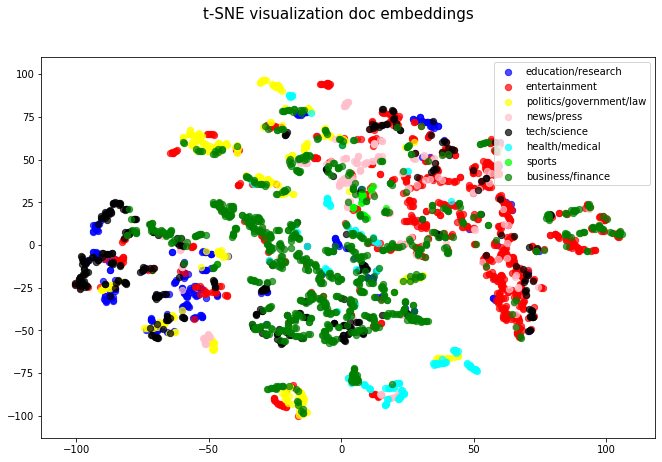

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def visualize_doc_embeddings(my_doc_embs, my_colors, my_labels, my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
    fig, ax = plt.subplots()
    
    for i, label in enumerate(list(set(my_labels))):
        idxs = [idx for idx,elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   c = my_colors[i],
                   label=str(label),
                   alpha=0.7,
                   s=40)
    ax.legend(scatterpoints=1)
    fig.suptitle('t-SNE visualization doc embeddings',fontsize=15)
    fig.set_size_inches(11,7)
    fig.savefig(my_name + '.png')
my_doc_embs = emb.detach().numpy()
visualize_doc_embeddings(my_doc_embs, ['blue','red', 'yellow', 'pink', 'black', 'cyan', 'lime', 'green'],df[df.val].target.tolist() , 'test')

In [0]:
### Evaluation finale du modèle
def func_tmp(x) :
  x = list(list(i) for i in x)
  x = np.array(x)
  return np.mean(x, axis=0)
import sklearn
tmp = df[df.val].copy()
features = transform_wavs_cnn([X_val[i] for i in idx_test], n_slice)
features = torch.FloatTensor(features)
adj = torch.FloatTensor(feats_val[idx_test])
model.eval()
y_pred_val, _ = model(features, adj)
y_pred_val = np.exp(y_pred_val.detach().numpy())
tmp ['pred'] = list(list(i) for i in y_pred_val)
tmp1 = tmp.groupby(['hosts', 'target'])['pred'].apply(lambda x: func_tmp(x)).reset_index()
y_val_true = pd.get_dummies(tmp1.target).values
y_pred_true = tmp1.pred.values.tolist()
y_pred_true = np.array(y_pred_true).reshape(len(y_pred_true),8)
print(sklearn.metrics.log_loss(y_val_true, y_pred_true))

1.2665274181237367


In [0]:
# Write predictions to a file
hosts_test = tmp1.hosts.tolist()
with open('text_baseline_ok.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list(np.unique(y_train))
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i, test_host in enumerate(test_hosts):
        i = hosts_test.index(test_host)
        lst = y_pred_true[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

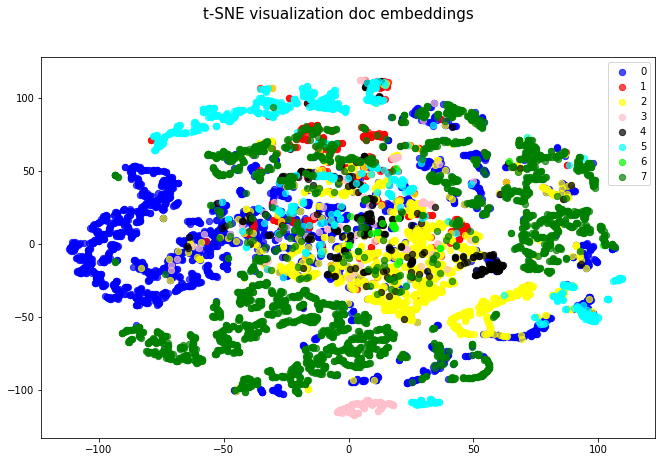

In [0]:
## TSNE of another configuration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def visualize_doc_embeddings(my_doc_embs, my_colors, my_labels, my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
    fig, ax = plt.subplots()
    
    for i, label in enumerate(list(set(my_labels))):
        idxs = [idx for idx,elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   c = my_colors[i],
                   label=str(label),
                   alpha=0.7,
                   s=40)
    ax.legend(scatterpoints=1)
    fig.suptitle('t-SNE visualization doc embeddings',fontsize=15)
    fig.set_size_inches(11,7)
    fig.savefig(my_name + '.png')
my_doc_embs = emb.detach().numpy()
visualize_doc_embeddings(my_doc_embs, ['blue','red', 'yellow', 'pink', 'black', 'cyan', 'lime', 'green'], Y_val_.detach().numpy(), 'test')

## GNN - Node classification in a graph with Deep Learning

In [0]:
sentences_train = []
for host in int_hosts :
  sentences_train.append(test_dict[host])

In [0]:
import scipy.sparse as sp
import numpy as np
def normalize_adjacency(A):
    ############## Task 9
    A_new = np.array(A) + np.eye(A.shape[0])
    D = np.diag(1/np.sqrt(np.sum(A_new, axis = 1)))
    A_normalized = (D.dot(A_new)).dot(D)
    return A_normalized

In [0]:
G_tmp = G.subgraph(train_hosts)
A = nx.adj_matrix(G_tmp).astype('float').toarray()
nodes_G = list(G_tmp.nodes())
index_hosts = []
for host in train_hosts :
  index_hosts.append(nodes_G.index(host))
A = A[index_hosts]
adj = normalize_adjacency(A) # Normalizes the adjacency matrix

In [0]:
import torch
import torch.nn as nn
import pdb
import torch.nn.functional as F

class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 and 13
        x = self.fc1(x_in)
        x = self.relu(torch.mm(adj, x))
        x = self.dropout(x)
        x = self.fc2(x)
        t = self.relu(torch.mm(adj, x))
        x = self.fc3(t)
        return F.log_softmax(x, dim=1), t

In [0]:
n = A.shape[0]
epochs = 100
n_hidden_1 = 32
n_hidden_2 = 64
dropout_rate = 0.15

In [0]:
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, log_loss
learning_rate = 0.001
idx_train = torch.LongTensor(np.arange(len(y_pred_final)))
idx_test = torch.LongTensor(np.arange(len(y_pred_val)))
data_loader = torch.utils.data.DataLoader(
    idx_train, batch_size=64, shuffle=True, num_workers=4)
model = GNN(8, n_hidden_1, n_hidden_2, 8, dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y_train_ = torch.LongTensor (le.fit_transform(Y_train))
Y_val = torch.LongTensor (le.fit_transform(y_val))
def accuracy(output, labels):
    """Computes classification accuracy"""
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [0]:
feat_trains = torch.FloatTensor(y_pred_final)
feat_val = torch.FloatTensor(y_pred_val)
adj = torch.FloatTensor(adj)
def train(epoch, features, idx_train, y,):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, _ = model(features[idx_train], adj[idx_train][:, idx_train])
    loss_train = F.nll_loss(output, y[idx_train])
    acc_train = accuracy(output, y[idx_train])
    loss_train.backward()
    optimizer.step()
    return loss_train, acc_train

def test(idx_test, features, y):
    model.eval()
    output, emb = model(features[idx_test], adj[idx_test][:, idx_test])
    loss_test = F.nll_loss(output, y[idx_test])
    acc_test = accuracy(output, y[idx_test])
    return loss_test, acc_test, emb

In [0]:
# Train model
epochs = 20
import time
t_total = time.time()
for epoch in range(epochs):
  for num_epoch, idx_tr in enumerate(data_loader):
    loss_train, acc_train = train(epoch, feat_trains, idx_tr, Y_train_)
    if num_epoch %16 == 0:
      loss_test, acc_test, emb = test(idx_test, feat_val, Y_val)
      print('Epoch: {:03d}'.format(epoch+1),
            'Batch: {:03d}'.format(num_epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'acc_train: {:.4f}'.format(acc_train.item()),
            "loss_val= {:.4f}".format(loss_test.item()),
            "accuracy_val= {:.4f}".format(acc_test.item()))
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 001 Batch: 001 loss_train: 1.5136 acc_train: 0.4844 loss_val= 1.7563 accuracy_val= 0.4400
Epoch: 001 Batch: 017 loss_train: 1.4710 acc_train: 0.4688 loss_val= 1.7485 accuracy_val= 0.4467
Epoch: 002 Batch: 001 loss_train: 1.5927 acc_train: 0.4219 loss_val= 1.7458 accuracy_val= 0.4633
Epoch: 002 Batch: 017 loss_train: 1.5463 acc_train: 0.5000 loss_val= 1.7426 accuracy_val= 0.4600
Epoch: 003 Batch: 001 loss_train: 1.5447 acc_train: 0.4844 loss_val= 1.7426 accuracy_val= 0.4567
Epoch: 003 Batch: 017 loss_train: 1.4276 acc_train: 0.5312 loss_val= 1.7434 accuracy_val= 0.4633
Epoch: 004 Batch: 001 loss_train: 1.5560 acc_train: 0.4531 loss_val= 1.7515 accuracy_val= 0.4467
Epoch: 004 Batch: 017 loss_train: 1.5508 acc_train: 0.4062 loss_val= 1.7584 accuracy_val= 0.4367
Epoch: 005 Batch: 001 loss_train: 1.9010 acc_train: 0.4688 loss_val= 1.7399 accuracy_val= 0.4567
Epoch: 005 Batch: 017 loss_train: 1.5814 acc_train: 0.4531 loss_val= 1.7316 accuracy_val= 0.4667
Epoch: 006 Batch: 001 loss_tra

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def visualize_doc_embeddings(my_doc_embs, my_colors, my_labels, my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
    fig, ax = plt.subplots()
    
    for i, label in enumerate(list(set(my_labels))):
        idxs = [idx for idx,elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   c = my_colors[i],
                   label=str(label),
                   alpha=0.7,
                   s=40)
    ax.legend(scatterpoints=1)
    fig.suptitle('t-SNE visualization doc embeddings',fontsize=15)
    fig.set_size_inches(11,7)
    fig.savefig(my_name + '.png')
my_doc_embs = emb.detach().numpy()
visualize_doc_embeddings(my_doc_embs, ['blue','red', 'yellow', 'pink', 'black', 'cyan', 'lime', 'green'], y_val, 'test')